In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import tensorflow as tf
from aml_dl.mdn.model import tf_pushing_model

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [5]:
KMIX = 2

In [6]:
net = tf_pushing_model(dim_input = 4, n_hidden = 1, n_kernels = KMIX)


In [7]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

## Load data

In [8]:
from aml_robot.box2d.data_manager import DataManager

In [9]:
data_manager = DataManager.from_file('data_test.pkl')

In [10]:
print data_manager.get_sample(0,'push_action')

[[ 0.          0.         -0.99312433 -0.11706435  3.25892604]]


In [11]:
data_x = data_manager.pack_data_x(['state_start','state_end'])

In [12]:
data_y = data_manager.pack_data_y()

In [13]:
print data_y

[[3.2589260428207698], [0.71406126015869187], [5.2814170059946601], [2.312810842651436], [1.3201492309055909], [0.55374437086760209], [1.3539647517455753], [0.3984449064976105], [3.7095766597637017], [0.067921115504014223], [4.4638630122487077], [3.6442943421196685], [1.0315220239671381], [5.346096058186073], [2.8564718038514676], [4.7429031135738553], [5.6300807755373254], [2.24293084710696], [5.5483668700778628], [5.8971969784892684], [0.73353995275548023], [4.2751308804229646], [2.7851047350677942], [2.5899367516217544], [2.5383242299562672], [2.3521941305640741], [2.9950881587017859], [1.4363866650019059], [5.4484000454729955], [5.4384209843209019], [1.0818480643735515], [0.31326442559741136], [1.7448119725306146], [0.088271978147171748], [0.51918544020194668], [4.6044561179847427], [4.4213566568401941], [6.0172684418663929], [1.3431674573194354], [2.8222261302617624], [4.0735957109909497], [5.192155499604973], [4.1200004714113057], [3.8942568721088104], [0.942650031197941], [1.939

In [25]:
h = sess.run(net['z_hidden'],feed_dict={net['x']: data_x})

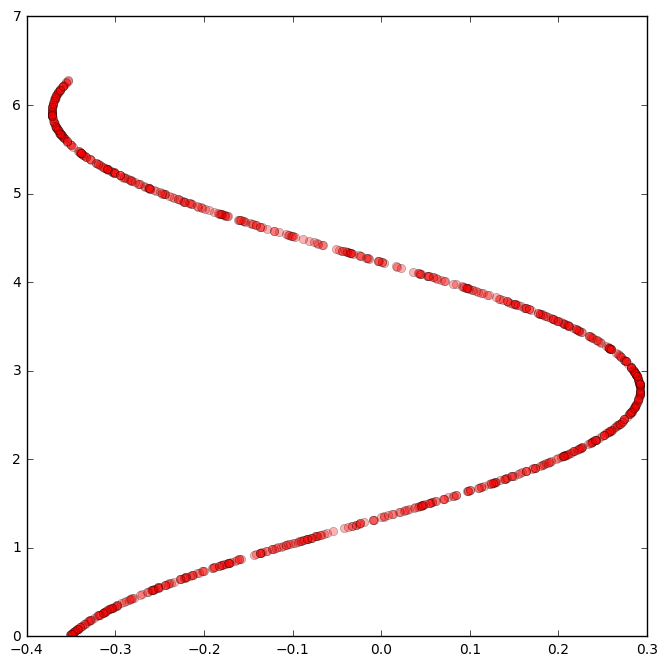

In [26]:
plt.figure(figsize=(8, 8))
plt.plot(h, data_y,'ro', alpha=0.3)
plt.show()

In [16]:
N_EPOCHS = 10000#10000
loss = np.zeros(N_EPOCHS) # store the training progress here.
for i in range(N_EPOCHS):
  sess.run(net['train'],feed_dict={net['x']: data_x, net['y']: data_y})
  loss[i] = sess.run(net['loss'], feed_dict={net['x']: data_x, net['y']: data_y})

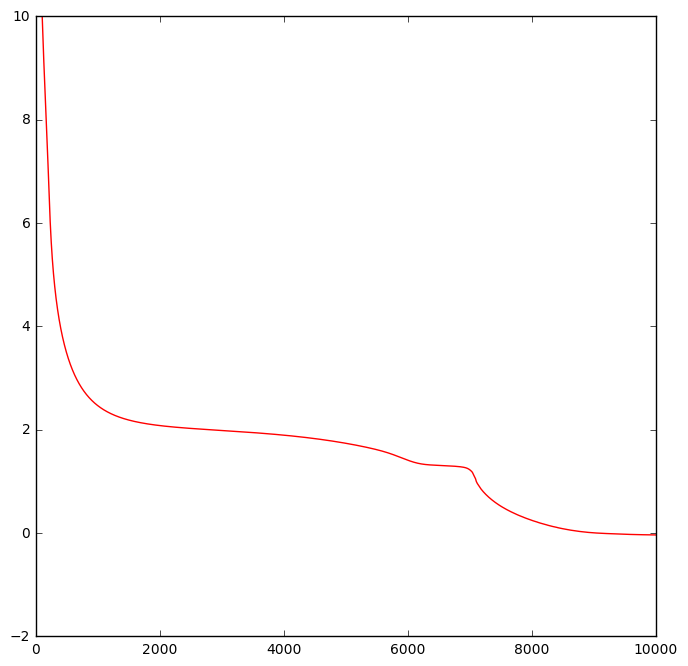

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, N_EPOCHS,1), loss[100:], 'r-')
plt.show()

In [18]:
h = sess.run(net['z_hidden'],feed_dict={net['x']: data_x})

In [30]:
N_SAMPLES = 1000
print N_SAMPLES
x_test = np.float32(np.random.uniform(-5.5, 5.5, (4, N_SAMPLES))).T
len(x_test)

1000


1000

In [31]:
h_test = sess.run(net['z_hidden'],feed_dict={net['x']: x_test})
NTEST = h_test.size
print NTEST
# x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

def get_pi_idx(x, pdf):
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  print 'error with sampling ensemble'
  return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
  NTEST = h_test.size
  result = np.random.rand(NTEST, M) # initially random [0, 1]
  rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
  mu = 0
  std = 0
  idx = 0

  # transforms result into random ensembles
  for j in range(0, M):
    for i in range(0, NTEST):
      idx = get_pi_idx(result[i, j], out_pi[i])
      mu = out_mu[i, idx]
      std = out_sigma[i, idx]
      result[i, j] = mu + rn[i, j]*std
  return result

1000


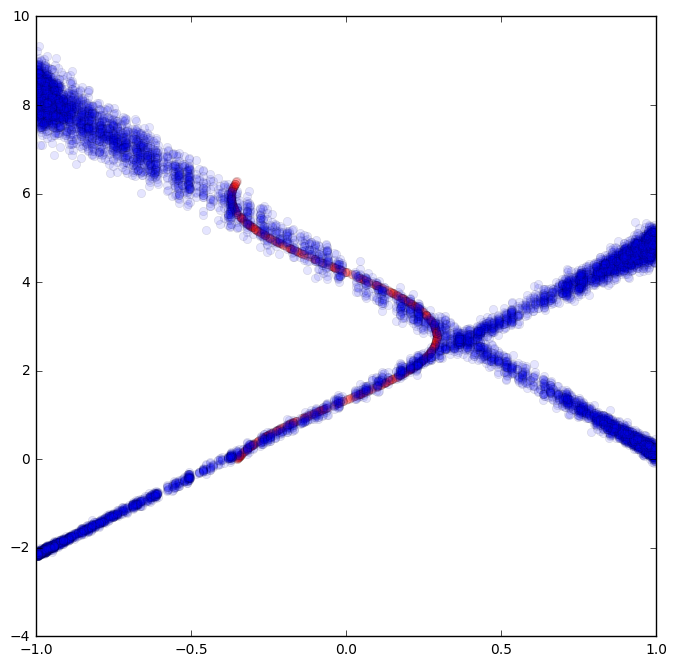

In [32]:
out_pi_test, out_sigma_test, out_mu_test = sess.run([net['pi'], net['sigma'], net['mu']], feed_dict={net['x']: x_test})

y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)

plt.figure(figsize=(8, 8))
plt.plot(h,data_y,'ro', h_test,y_test,'bo',alpha=0.1)
plt.show()

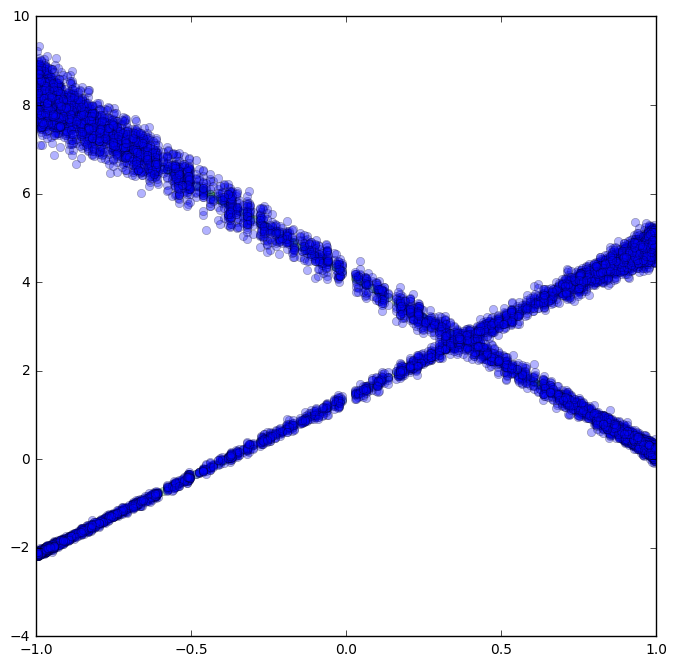

In [33]:
plt.figure(figsize=(8, 8))
plt.plot(h_test,out_mu_test,'go', h_test,y_test,'bo',alpha=0.3)
plt.show()

In [58]:
len(out_pi_test)
x_heatmap_label = np.float32(np.arange(-6,6,0.02))
y_heatmap_label = np.float32(np.arange(-6,6,0.02))

len(x_heatmap_label)

600

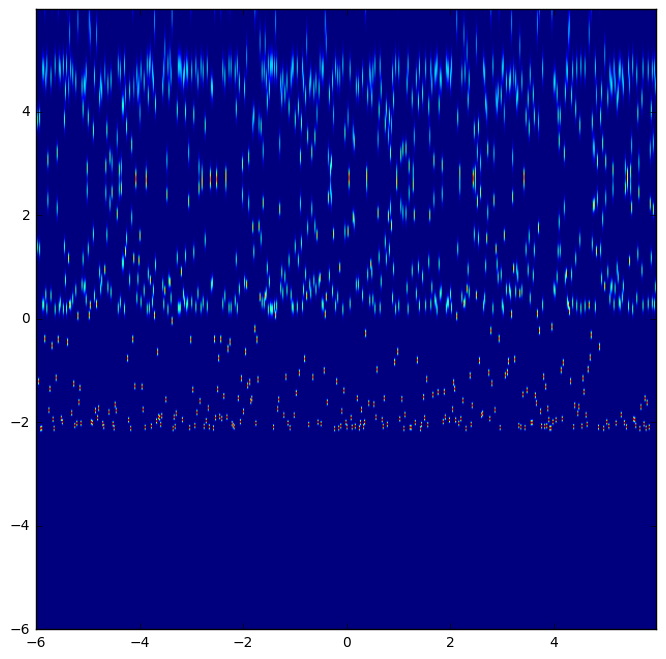

In [59]:


def custom_gaussian(x, mu, std):
  oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
  x_norm = (x-mu)/std
  result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
  return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
  N = x_heatmap_label.size
  M = y_heatmap_label.size
  K = KMIX

  z = np.zeros((N, M)) # initially random [0, 1]

  mu = 0
  std = 0
  pi = 0

  # transforms result into random ensembles
  for k in range(0, K):
    for i in range(0, M):
      pi = out_pi[i, k]
      mu = out_mu[i, k]
      std = out_sigma[i, k]
      for j in range(0, N):
        z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)

  return z

def draw_heatmap(xedges, yedges, heatmap):
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  plt.figure(figsize=(8, 8))
  plt.imshow(heatmap, extent=extent)
  plt.show()

z = generate_heatmap(out_pi_test, out_mu_test, out_sigma_test, x_heatmap_label, y_heatmap_label)
draw_heatmap(x_heatmap_label, y_heatmap_label, z)